# Adjusting initial conditions

This notebook teaches you how to change the initial conditions of the disk.

First we create a new directory and change to it.

In [1]:
example_name = "301_Adjusting_Inditial_Conditions"
example_dir = f"example_dirs/{example_name}"
import os
if not os.path.basename(os.getcwd()) == example_name:
    !mkdir -p $example_dir
    os.chdir(example_dir)
repo_root = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
print(f"Current working directory: {os.getcwd()}")
print(f"Repository root directory: {repo_root}")

Current working directory: /home/rometsch/repo/fargocpt/examples/example_dirs/301_Adjusting_Inditial_Conditions
Repository root directory: /home/rometsch/repo/fargocpt


## Make sure the code is built by running make again.

In [2]:
%%timeit -n1 -r1
from sys import platform
if platform in ["linux", "darwin"]:
    !make -j 4 -C ../../src > make.log
else:
    raise RuntimeError(f"Seems like you are not running MacOS or Linux but {platform}. This is unsupported. You are on your own, good luck!")

make: *** ../../src: No such file or directory.  Stop.
110 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Preparing a setup file

We'll take the example setup file from the examples directory and modify it in python.
If you want to create setup files for a parameter study, just copy the code and make your own setup creator script.

In [3]:
configfile = "setup.yml"
!cp $repo_root/examples/config.yml $configfile

We'll use the `ruamel.yaml` package to read and write the setup file. This can be set up to preserve comments which is very useful if you want to trace your decisions later on.

In [4]:
try:
    import ruamel.yaml
except ImportError:
    raise ImportError("Please install ruamel.yaml with `python3 -m pip install ruamel.yaml`")
yamlparser = ruamel.yaml.YAML()
with open(configfile, "r") as infile:
    config = yamlparser.load(infile)

In [5]:
# we don't need to run long to inspect the initial conditions
config["MonitorTimestep"] = 0.314 # monitor scalar files around every half orbit
config["Nmonitor"] = 1 # write a snapshot every orbit
config["Nsnapshots"] = 1 # wirte 100 snapshots

# use very low resolution by setting it to 2 cell per scaleheight, cps
config["cps"] = 2

# set initial conditions of the powerlaw disk
config["SigmaSlope"] = 1.5 # Sigma(r) = Sigma0 * r**(-SigmaSlope)
config["Sigma0"] = "100 g/cm2" # we can use units here

# also, lets set a different temperature profile via the aspect ratio
config["AspectRatio"] = 0.1

# write out temperature and aspect ratio, so we can plot it
config["WriteTemperature"] = True
config["WriteAspectRatio"] = True

with open(configfile, "w") as outfile:
    yamlparser.dump(config, outfile)

## Run the simulation

In [6]:
from fargocpt import run
run(["start", configfile], np=2, nt=1, exe=repo_root+"/bin/fargocpt_exe", detach=False)

Running command: mpirun -np 2 --report-pid /tmp/tmp34swwsrv -x OMP_NUM_THREADS=1 /home/rometsch/repo/fargocpt/bin/fargocpt_exe start setup.yml
fargo process pid 1410280

[0] MPI rank #  0 runs as process 1410284
[1] MPI rank #  1 runs as process 1410285
[1] MPI rank #  1 OpenMP thread #  0 of  1 on cpt-kamino
[0] MPI rank #  0 OpenMP thread #  0 of  1 on cpt-kamino
[0] fargo: This file was compiled on Nov 14 2023, 12:56:40.
[0] fargo: This version of FARGO used _GNU_SOURCE
[0] fargo: This version of FARGO used NDEBUG. So no assertion checks!
[0] Using parameter file setup.yml
[0] Computing disk quantities within 5.00000e+00 L0 from coordinate center
[0] BC: Inner composite = reflecting
[0] BC: Outer composite = reflecting
[0] BC: Sigma inner = zerogradient
[0] BC: Sigma outer = zerogradient
[0] BC: Energy inner = zerogradient
[0] BC: Energy outer = zerogradient
[0] BC: Vrad inner = reflecting
[0] BC: Vrad outer = reflecting
[0] BC: Vaz inner = keplerian
[0] BC: Vaz outer = keplerian
[0

0

Following is an overview widget for the simulation. You can use the slider to scrub through the different snapshots.

Let's see which variables we have.

In [7]:
from fargocpt import Loader
l = Loader("output/out")
l.gas.vars2D

   Vars2D
| output_dir: output/out
| target_units= None
| grid: Grid
| var_names:
|   Sigma
|   vrad
|   vazi
|   energy
|   Temperature
|   aspectratio

Run the next cell again to refresh the snapshot list.

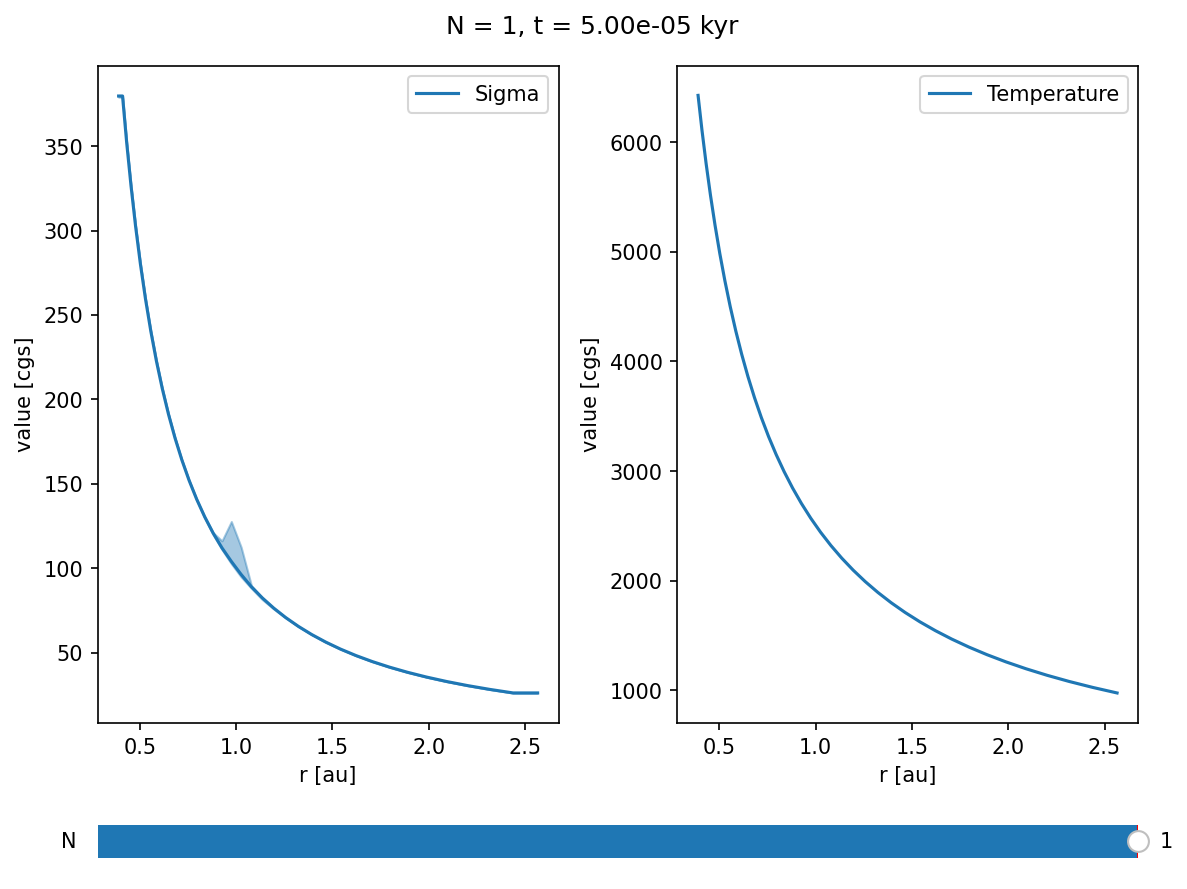

In [9]:
# %matplotlib widget
from fargocpt import Overview
overview = Overview("output/out/", 
                    vars=["1:Sigma:minmax",
                          "1:Temperature"])
overview.create();